Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [1]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image 

# Для отрисовки графиков
import matplotlib.pyplot as plt 

# Для генерации случайных чисел 
import random 

# Библиотека работы с массивами
import numpy as np 

# Для работы с файлами 
import os 

# импортируем модуль для загрузки данных
import gdown 

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, SpatialDropout2D

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam 

# модуль для отсчета времени
import time 

In [2]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива 
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True) 

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus  

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/' 

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH) 

['Входящий', 'Выходящий']

In [3]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [4]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['06008.jpg', '05317.jpg', '01645.jpg', '04166.jpg', '04557.jpg', '03692.jpg', '05117.jpg', '05628.jpg', '02305.jpg', '03518.jpg', '01822.jpg', '03149.jpg', '00903.jpg', '05917.jpg', '03754.jpg', '05135.jpg', '00551.jpg', '00049.jpg', '00837.jpg', '06255.jpg', '02600.jpg', '05176.jpg', '02482.jpg', '04154.jpg', '06470.jpg', '01022.jpg', '00149.jpg', '04018.jpg', '02924.jpg', '03549.jpg', '04034.jpg', '04326.jpg', '00834.jpg', '03271.jpg', '04444.jpg', '03358.jpg', '00196.jpg', '00163.jpg', '02080.jpg', '05840.jpg', '05427.jpg', '03604.jpg', '04555.jpg', '01761.jpg', '00978.jpg', '00029.jpg', '03380.jpg', '04350.jpg', '04902.jpg', '03696.jpg', '01174.jpg', '05432.jpg', '01149.jpg', '06044.jpg', '04218.jpg', '05633.jpg', '04876.jpg', '03981.jpg', '05328.jpg', '01902.jpg', '01340.jpg', '04356.jpg', '05361.jpg', '06416.jpg', '01482.jpg', '02499.jpg', '02091.jpg', '05302.jpg', '02391.jpg', '05365.jpg', '05441.jpg', '02797.jpg', '03769.jpg', '02489.jpg', '01204.jpg', '00244.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

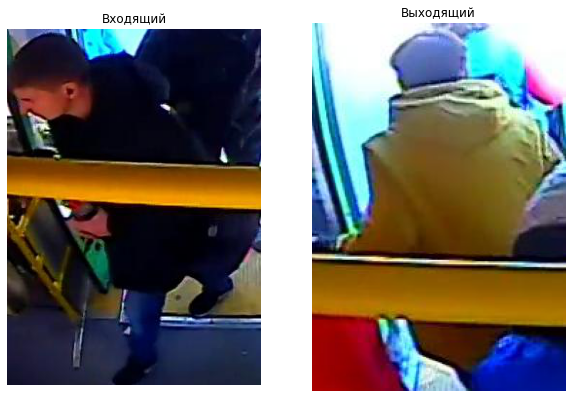

In [5]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 10))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path)) 
    
    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))  
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [6]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [7]:
# ваше решение

# Задание высоты и ширины загружаемых изображений
IMG_HEIGHT = 32
IMG_WIDTH = 64
# для изображений
data_images = []                          

for name in data_files:
    img = Image.open(name).resize((IMG_HEIGHT, IMG_WIDTH)).convert("L")
    img_np = np.array(img)                # делаем np-массив
    data_images.append(img_np)            # добавляем в список

xTrain = np.array(data_images).reshape(-1,32,64,1)  # делаем xTrain
yTrain = np.array(data_labels)                      # делаем yTrain

print(f'Всего {len(data_images)} форма: {img_np.shape}\
\nx_data.shape: {xTrain.shape}\nклассов: {yTrain.shape}')

Всего 9081 форма: (64, 32)
x_data.shape: (9081, 32, 64, 1)
классов: (9081,)


In [8]:
xTrain = xTrain / 255.  # нормализуем значения в диапазон 0-1

img_height = 32
img_width = 64
chanels = 1 

input_shape = (img_height, img_width, chanels)
input_shape

(32, 64, 1)

In [9]:
model = Sequential()


model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(input_shape)))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax')) # Выходной полносвязный слой с количеством нейронов 1, т.к. бинарная классификация

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 64, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 32, 64, 16)       64        
 ormalization)                                                   
                                                                 
 spatial_dropout2d (SpatialD  (None, 32, 64, 16)       0         
 ropout2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 64, 32)       128       
 hNormalization)                                                 
                                                        

## Эксперимент 1

Epoch 1/50
54/54 [==============================] - 15s 34ms/step - loss: 0.3546 - accuracy: 0.8661 - val_loss: 1.6121 - val_accuracy: 0.0000e+00
Epoch 2/50
54/54 [==============================] - 1s 27ms/step - loss: 0.2444 - accuracy: 0.9273 - val_loss: 2.4723 - val_accuracy: 0.0000e+00
Epoch 3/50
54/54 [==============================] - 1s 26ms/step - loss: 0.2090 - accuracy: 0.9388 - val_loss: 2.7262 - val_accuracy: 0.0000e+00
Epoch 4/50
54/54 [==============================] - 1s 25ms/step - loss: 0.1861 - accuracy: 0.9446 - val_loss: 2.9357 - val_accuracy: 0.0000e+00
Epoch 5/50
54/54 [==============================] - 1s 23ms/step - loss: 0.1701 - accuracy: 0.9504 - val_loss: 3.1474 - val_accuracy: 0.0000e+00
Epoch 6/50
54/54 [==============================] - 1s 24ms/step - loss: 0.1503 - accuracy: 0.9558 - val_loss: 2.8959 - val_accuracy: 0.0000e+00
Epoch 7/50
54/54 [==============================] - 1s 24ms/step - loss: 0.1437 - accuracy: 0.9595 - val_loss: 2.8834 - val_accur

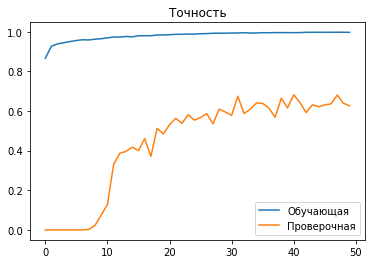

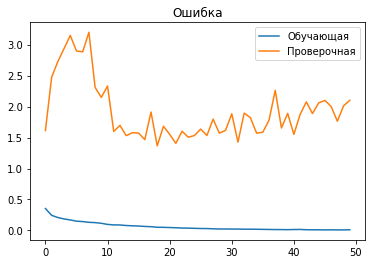

In [11]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

store = model.fit(xTrain, yTrain,                # данные и метки данных
                  shuffle=True, batch_size=128,  # перемешиваем и указываем размер выборки для тренировки
                  epochs=50, validation_split=0.25,  # количество тренировок и 25% данных для проверки
                  verbose=1)                         # 1 показать ход обучения 0-скрыть
plt.plot(store.history['accuracy'], label='Обучающая')
plt.plot(store.history['val_accuracy'], label='Проверочная')
plt.legend()
plt.title('Точность')
plt.show()
plt.plot(store.history['loss'], label='Обучающая')
plt.plot(store.history['val_loss'], label='Проверочная')
plt.legend()
plt.title('Ошибка')
plt.show()

# Дообучение 

Epoch 1/50
16/16 [==============================] - 7s 114ms/step - loss: 0.2170 - accuracy: 0.9496 - val_loss: 0.3961 - val_accuracy: 0.8921
Epoch 2/50
16/16 [==============================] - 1s 75ms/step - loss: 0.1089 - accuracy: 0.9675 - val_loss: 0.3199 - val_accuracy: 0.9120
Epoch 3/50
16/16 [==============================] - 1s 80ms/step - loss: 0.0842 - accuracy: 0.9749 - val_loss: 0.3215 - val_accuracy: 0.9098
Epoch 4/50
16/16 [==============================] - 1s 94ms/step - loss: 0.0717 - accuracy: 0.9777 - val_loss: 0.2831 - val_accuracy: 0.9178
Epoch 5/50
16/16 [==============================] - 2s 99ms/step - loss: 0.0629 - accuracy: 0.9788 - val_loss: 0.2850 - val_accuracy: 0.9222
Epoch 6/50
16/16 [==============================] - 1s 85ms/step - loss: 0.0541 - accuracy: 0.9800 - val_loss: 0.2442 - val_accuracy: 0.9274
Epoch 7/50
16/16 [==============================] - 1s 79ms/step - loss: 0.0467 - accuracy: 0.9837 - val_loss: 0.2695 - val_accuracy: 0.9274
Epoch 8/50
1

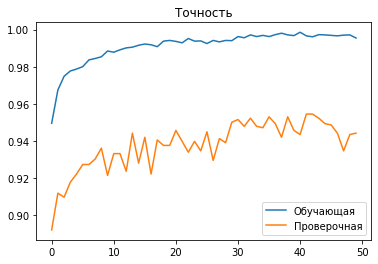

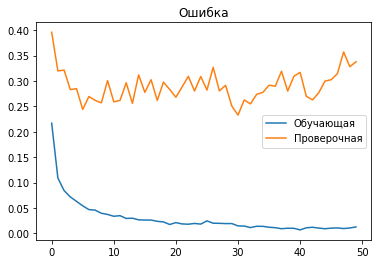

In [12]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

store = model.fit(xTrain, yTrain,    
                  shuffle=True, batch_size=512,     # batch 512
                  epochs=50, validation_split=0.15,  # 15% данных для проверки
                  verbose=1) 
plt.plot(store.history['accuracy'], label='Обучающая')
plt.plot(store.history['val_accuracy'], label='Проверочная')
plt.legend()
plt.title('Точность')
plt.show()
plt.plot(store.history['loss'], label='Обучающая')
plt.plot(store.history['val_loss'], label='Проверочная')
plt.legend()
plt.title('Ошибка')
plt.show()